In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import line

In [3]:
input_image = plt.imread('FigPaper.tif')
# plt.imshow(input_image,cmap=plt.cm.gray)
# plt.gca().invert_yaxis()

In [4]:
def my_paper_detection(input_image):
  """Description:
    This function extracts a paper by using the Hough transform method.
    Not all four paper corners are visible in the image, e.g., one may be missing due to paper folding.
    The paper is not in rectangular shape due to viewpoint change.
    It is assumed that the paper has clear boundary.
    The implementation of the Hough transform follows the details given in the Line and Circle Detection lecture notes and tutorial.
    The implementation of the geometric transformations follows the details given in the lecture notes and tutorial.
    Intensity values outside the image region are assumed zero.

    Parameter: input_image = input array representing an image.
    There is only one paper inside the image.
    The paper shape may not be rectangular.
    Some paper corners may be missing.

    Return:
    new_image_line = an original image with four white straight line segments (intensity = 255) outlining the paper boundaries. 
      For each straight line segment, it represents one side of the paper.
    new_image_rotate = the rotated version of new_image_line with the short sides of the paper parallel with a horizontal line.
      The rotation center is the left end of the straight line segment lying on the lower short side. (Bottom left corner.)
      The image sizes of new_image_rotate and new_image_line are the same. Empty space is zero-padded. 
    new_image_shear = the sheared version of the new_image_rotate with the long sides parallel with a vertical line.
      The shear center is the left end of the straight line segment lying on the lower short side. (Bottom left corner.)
      The image sizes of new_image_shear and new_image_rotate are the same. Empty space is zero-padded. 
    new_image_region = a binary, black-and-white image.
        The black region (intensity = 0) corresponds to the image background.
        The white region (intensity = 255) corresponds to the region enclosed by the four straight line segments after rotation and shear.

    Requirements:
    Pre-defined functions for Hough transform cannot be used.
    Pre-defined functions for filtering, convolution, correlation cannot be used, e.g., filter2D.
    Pre-defined functions for rotation, shearing, and geometric transformation cannot be used.
    You must use double for-loop for accessing pixels in the input image.

    Marking criteria:
    The output images will be marked.
    No mark if the operation is not Hough transform and geometric transformation.
    No mark if the implementation does not follow details given the lecture notes and tutorial.
    Mark deduction if image aliasing is observed. 
    Partial marking is possible.
  """

  # create a new image which is identical to input image
  H, W = input_image.shape
  new_image_line = np.zeros((H, W))
  new_image_rotate = np.zeros((H, W))
  new_image_shear = np.zeros((H, W))
  new_image_region = np.zeros((H, W))

  ############################
  # [Your code goes here]
  ############################
  def flip_img(input_image):
    '''
    flip around middle of y axis
    '''
    H , W = input_image.shape
    flipped_image = np.zeros((H,W))
    for i in range(H):
        for j in range(W):
            flipped_image[i,j] = input_image[(H-1) - i , j]
    return flipped_image
  
  def simple_threshold(input_image):
    H,W = input_image.shape
    new_image = np.zeros((H,W))
    # find threshold
    threshold = 0
    max_iter=20
    for _ in range(max_iter):
        m1 = np.mean(input_image[input_image > threshold])
        m2 = np.mean(input_image[input_image <= threshold])
        # print(m1 , m2 , threshold)
        threshold = 0.5*(m1+m2)
    for i in range(H):
        for j in range(W):
            if input_image[i,j] > threshold:
                new_image[i,j] = 255
            else:
                new_image[i,j] = 0
    return new_image
  
  def grad_mag(input_image, pad = 1, thresh=99.99):
    '''
    returns gradient magnitude of image
    '''
    # sobel filters
    sobelx = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    sobely = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    # create padded img
    padded_image = np.pad(input_image , ((pad , pad),(pad , pad)) , mode = 'constant')
    # create new blank image
    H , W = padded_image.shape
    thresh_image_grad , image_grad , image_angle = np.zeros((H,W)) , np.zeros((H,W)) , np.zeros((H,W))
    # blur image
    for i in range(pad , H - pad):
        for j in range(pad , W - pad):
            A = padded_image[i-pad:i+pad+1 , j-pad:j+pad+1]
            gx = np.sum(A*sobelx)
            gy = np.sum(A*sobely)
            image_grad[i,j] = np.sqrt(gx**2 + gy**2) #np.abs(gx) + np.abs(gy)
            image_angle[i,j] = np.arctan2(gy,gx)
    # Rescale
    image_grad = (image_grad - np.min(image_grad))/(np.max(image_grad) - np.min(image_grad))*255

    return image_grad[pad:-pad , pad:-pad] , image_angle[pad:-pad , pad:-pad]
  
  def nms(G , theta):
    ################################
    # Step 4: Non-maximal Suppresion
    ################################
    '''
    Resource: https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
    '''
    H,W = G.shape
    Z = np.zeros((H,W), dtype=np.int32) #init zero valued array of same shape
    angle = theta * 180/np.pi # convert to degree
    angle[angle < 0] += 180
            
    for i in range(1,H-1):
        for j in range(1,W-1):
            try:
                # Assigning neighbouring pixels based on the gradient angle
                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    p = G[i, j+1]
                    r = G[i, j-1]
                #angle 45/135
                elif (22.5 <= angle[i,j] < 67.5) or (112.5 <= angle[i,j] < 157.5): # pedantically, p and r should flip for the 'OR' condition, but computationally it's the same
                    p = G[i+1, j-1]
                    r = G[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    p = G[i+1, j]
                    r = G[i-1, j]
                if (G[i,j] >= p) and (G[i,j] >= r): # Is the middle pixel brighter than both its neighbours?
                    Z[i,j] = G[i,j]
                else:
                    Z[i,j] = 0
                    
            except IndexError as e:
                pass
    return Z
  
  def my_hough_transform(edge_img, intensity_threshold = 250 , points_threshold = 150):
    '''
    param edge_img : image with edges obtained after applying edge detection
    param threshold : lines with at least this number of points on them
    param percentile : the top 100 - percentile brightest pixels will be selected
    '''
    #diagonal length of image
    D = np.sqrt(edge_img.shape[0]**2+edge_img.shape[1]**2)
    #theta range -> 0 degree, 180 degree since origin is at the bottom left of the image
    #rho range -> 0, -diagonal length to +diagonal length
    theta_range = 180
    rho_range = int(D)
    #build accumulator
    accumulator = np.zeros((2*rho_range , theta_range))
    # Threshold to get edges pixel location (x,y) - brightest percentile of pixels
    edge_pixels = np.where(edge_img >= intensity_threshold)
    coordinates = list(zip(edge_pixels[0], edge_pixels[1]))
    # Calculate rho value for each edge location (x,y) with all the theta range
    for p in range(len(coordinates)):
        for t in range(theta_range):
            rho = int(round(coordinates[p][1] * np.cos(np.deg2rad(t)) + coordinates[p][0] * np.sin(np.deg2rad(t)))) # beware the flipping convention
            accumulator[rho + rho_range, t] += 1
            
    rho , theta = np.where(accumulator > points_threshold)
    return rho - rho_range , theta
  
  def draw_lines(img , rho_pruned , theta_pruned):
    '''
    param img -> input_image
    param edges -> gradient intensity map
    param rho_pruned -> rho values for those lines with greater than a threshold number of points on them
    param theta_pruned -> theta values for those lines with greater than a threshold number of points on them
    param seg_thresh -> segmentation threshold for curtailing lines
    '''
    def det(a ,b):
        return a[0]*b[1] - a[1]*b[0]
    
    img_copy = img.copy()
    H , W = img.shape
    # new_image = np.zeros((H,W))
    lines = []
    intsxn_pt = []
    # Below few lines have been adapted from https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html
    for (rho_i , theta_i) in list(zip(rho_pruned , theta_pruned)):
        a = np.cos(np.deg2rad(theta_i))
        b = np.sin(np.deg2rad(theta_i))
        x0 = int(np.round(a*rho_i))
        y0 = int(np.round(b*rho_i))
        x1 = int(np.round(x0 + 2000*(-b)))
        y1 = int(np.round(y0 + 2000*(a)))
        x2 = int(np.round(x0 - 2000*(-b)))
        y2 = int(np.round(y0 - 2000*(a)))
        # Create line
        rr , cc = line(y1,x1,y2,x2)
        
        # Append the new line's begin and end pt to an array
        lines.append([[rr[0] , cc[0]] ,[rr[-1] , cc[-1]]])
    # Getting the intersection points of above lines
    # Code has been adapted from Paul Draper in https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines
    for i  in range(len(lines)-1):
        for j in range(i+1 , len(lines)):
            xdiff = lines[i][0][0] - lines[i][1][0] , lines[j][0][0] - lines[j][1][0]  
            ydiff = lines[i][0][1] - lines[i][1][1] , lines[j][0][1] - lines[j][1][1] 
            # Check for parallel lines, in which case, they won't intersect
            div = det(xdiff , ydiff)
            if div == 0:
                continue
            d = (det(*lines[i]) , det(*lines[j]))
            x = det(d , xdiff)/div
            y = det(d , ydiff)/div
            # Add interscetion point to array
            intsxn_pt.append((x.astype('int'),y.astype('int')))
    # Create lines between intersection points
    for i in range(len(intsxn_pt)-1):
        for j in range(i+1 , len(intsxn_pt)):
            if (i==0 and j==3) or (i==1 and j==2): # so that diagonal points aren't linked
                continue
            pt1 , pt2 = intsxn_pt[i] , intsxn_pt[j]
            rr , cc = line(pt1[0] , pt1[1] , pt2[0] , pt2[1])
            img_copy[rr , cc] = 255 # mark the lines as white, finally!
    return img_copy , intsxn_pt , lines
  
  # Main code
  # input_image = flip_img(input_image) # flipping it here as it will be easier during the rotation part!
  thresh_image_grad , image_angle = grad_mag(simple_threshold(input_image) , pad = 1, thresh = 99)
  nms_thresh_image = nms(thresh_image_grad , image_angle)
  rho , theta = my_hough_transform(nms_thresh_image , intensity_threshold = 250 , points_threshold = 100)
  img , points , lines = draw_lines(input_image*0.25 , rho , theta)

  return img , points , lines , rho , theta
  ############################
  # [Your code ends here]
  ############################

  # return new_image_line, new_image_rotate, new_image_shear, new_image_region

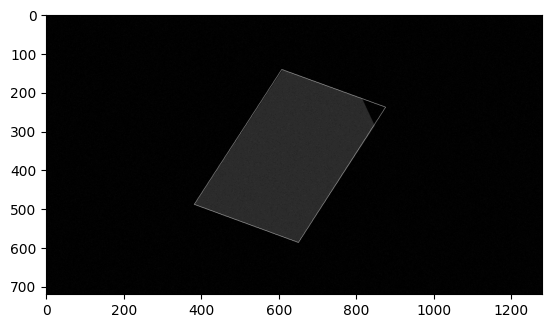

In [6]:
output_image , intsxn_pt , lines , rho , theta = my_paper_detection(input_image)
plt.imshow(output_image , cmap=plt.cm.gray , vmin = 0 , vmax = 255)
# plt.gca().invert_yaxis()
# rho , theta

In [7]:
def rotate(input_image , line_coords):
    #compute rotation agnle
    x1, y1 = line_coords[0]
    x2, y2 = line_coords[1]
    # theta = 270+np.arctan2(y2 - y1 , x2 - x1)*180/np.pi
    theta = np.arctan2(y2 - y1 , x2 - x1)*180/np.pi - 90

    # Create output
    output_image = np.zeros_like(input_image)

    # centre of rotation
    center_x = x1
    center_y = y1

    # size of img
    H , W = input_image.shape
    
    cos_theta = np.cos(np.deg2rad(theta))
    sin_theta = np.sin(np.deg2rad(theta))

    for y in range(H):
        for x in range(W):
            # Compute the new coordinates in the rotated image
            x_new = int((x - center_x) * cos_theta - (y - center_y) * sin_theta + center_x)
            y_new = int((x - center_x) * sin_theta + (y - center_y) * cos_theta + center_y)
            
            # Check if the new coordinates fall within the bounds of the output image
            if x_new >= 0 and x_new < W and y_new >= 0 and y_new < H:
                # Set the pixel intensity in the output image to the intensity of the corresponding pixel in the input image
                output_image[y_new, x_new] = input_image[y, x]
    return output_image

In [12]:
output_img = rotate(output_image , intsxn_pt[-2:])
# plt.imshow(input_image , cmap=plt.cm.gray)
# plt.gca().invert_yaxis()
# plt.scatter(np.array(intsxn_pt)[:,1] , np.array(intsxn_pt)[:,0])
# intsxn_pt[-2:]

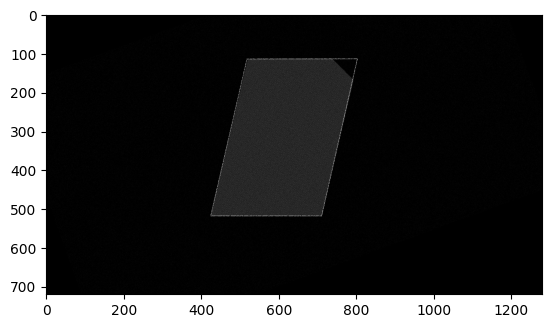

In [13]:
plt.imshow(output_img , cmap=plt.cm.gray)
# plt.scatter(np.array(intsxn_pt)[:,1] , np.array(intsxn_pt)[:,0])
# plt.scatter(shear_res[0] , shear_res[2])
# plt.scatter(shear_res[1] , shear_res[3])
# plt.gca().invert_yaxis()
# plt.grid();

In [26]:
def shear(input_image , theta):
    shr = np.tan(np.deg2rad(90-(np.max(theta) - np.min(theta))))
    H , W = input_image.shape
    new_width = W + abs(shr) *H
    output_img_shr = np.zeros((H , int(new_width)))
    # output_img_shr = np.zeros((H , W))
    # collect all new coords
    collect = []
    for y in range(H):
        for x in range(W):
            # compute new coords
            x_new = int(x + shr*y)
            # y_new = int(y)
            output_img_shr[y, x_new] = input_image[y, x]
            if input_image[y,x] >= 150:
                collect.append([y , x_new])
            # # Check if the new coordinates fall within the bounds of the output image
            # if x_new >= 0 and x_new < W and y_new >= 0 and y_new < H:
            #     # Set the pixel intensity in the output image to the intensity of the corresponding pixel in the input image
            #     output_image[y_new, x_new] = input_image[y, x]
    return output_img_shr , np.array(collect)

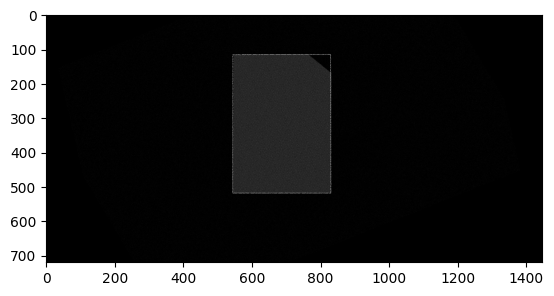

In [27]:
output_img_shr , collect = shear(output_img , theta)
plt.imshow(output_img_shr , cmap = plt.cm.gray)

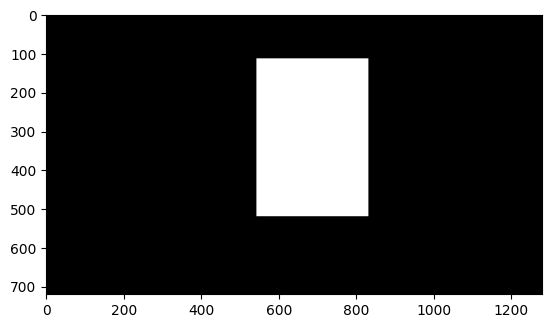

In [58]:
v_1 = min(collect[:,0])
v_2 = max(collect[:,0])
h_1 = min(collect[:,1])
h_2 = max(collect[:,1])
# v_1 , v_2 , h_1 , h_2

H , W = input_image.shape
new_image_region = np.zeros_like(input_image)

for y in range(H):
    for x in range(W):
        if (x >= h_1 and x <= h_2) and (y >= v_1 and y <= v_2):
            new_image_region[y , x] = 255

plt.imshow(new_image_region , cmap = plt.cm.gray)

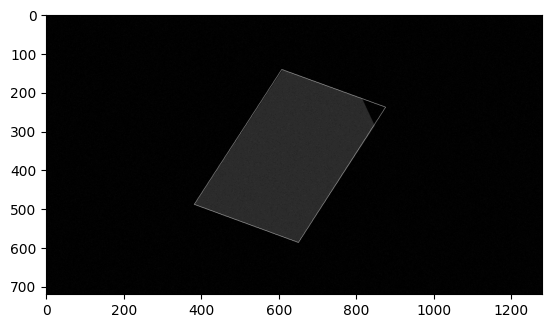

In [ ]:
output_image , intsxn_pt , lines , rho , theta = my_paper_detection(input_image)
plt.imshow(output_image , cmap=plt.cm.gray , vmin = 0 , vmax = 255)
# plt.gca().invert_yaxis()
# rho , theta

In [42]:
np.min(np.min(collect,axis=1)) , np.max(np.min(collect,axis=1))

(114, 519)

In [45]:
np.min(np.max(collect,axis=0)) , np.max(np.max(collect,axis=0))

(519, 831)

(528.6, 845.4, 93.75, 539.25)

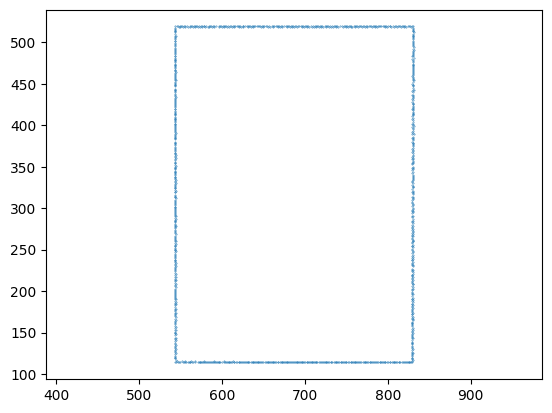

In [31]:
plt.scatter(collect[:,1] , collect[:,0] , s = 0.1)
plt.axis('equal')

In [56]:
v_1 = min(collect[:,0])
v_2 = max(collect[:,0])
h_1 = min(collect[:,1])
h_2 = max(collect[:,1])
v_1 , v_2 , h_1 , h_2

(114, 519, 543, 831)

NameError: name 'H' is not defined

In [51]:
collect.shape , collect[:,0].shape

((1129, 2), (1129,))

In [154]:
def shear(flip_line_coords , line_):
    #compute rotation agnle
    x1, y1 = flip_line_coords[0]
    x2, y2 = flip_line_coords[1]
    # theta = 270+np.arctan2(y2 - y1 , x2 - x1)*180/np.pi
    theta = np.arctan2(y2 - y1 , x2 - x1)*180/np.pi - 90
    print(theta)
    cos_theta = np.cos(np.deg2rad(theta))
    sin_theta = np.sin(np.deg2rad(theta))

    x1_ , y1_= line_[0]
    x2_ , y2_= line_[1]
    print(x1_ , y1_ , x2_ , y2_)
    y1_rotated = (x1_ - x1)*sin_theta + (y1_ - y1)*cos_theta + y1
    y2_rotated = (x2_-x2)*sin_theta + (y2_ - y2)*cos_theta + y1
    
    x1_rotated = (x1_-x1)*cos_theta - (y1_-y1)*sin_theta + x1
    x2_rotated = (x2_-x2)*cos_theta - (y2_-y2)*sin_theta + x1

    return x1_rotated , x2_rotated , y1_rotated , y2_rotated
    # return np.abs(x1_rotated - x2_rotated) , x1 , y1 , x2 , y2 , x1_ , y1_

In [271]:
rho , theta
np.max(theta) - np.min(theta)

77

In [272]:
shr = np.tan(np.deg2rad(90-(np.max(theta) - np.min(theta))))
shr

0.23086819112556312

In [273]:
H , W = output_img.shape
new_width = W + abs(shr) *H
output_img_shr = np.zeros((H , int(new_width)))
# output_img_shr = np.zeros((H , W))

for y in range(H):
    for x in range(W):
        # compute new coords
        x_new = int(x + shr*y)
        y_new = int(y)
        # print(y_new, x_new)
        output_img_shr[y_new, x_new] = output_img[y, x]

        # # Check if the new coordinates fall within the bounds of the output image
        # if x_new >= 0 and x_new < W and y_new >= 0 and y_new < H:
        #     # Set the pixel intensity in the output image to the intensity of the corresponding pixel in the input image
        #     output_image[y_new, x_new] = input_image[y, x]

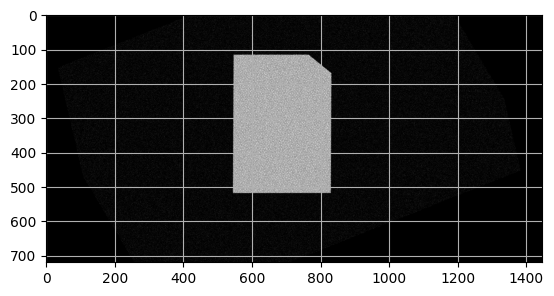

In [274]:
plt.imshow(output_img_shr , cmap=plt.cm.gray)
plt.grid()

In [92]:
np.array(intsxn_pt) , np.array(intsxn_pt)[:,1] , np.array(intsxn_pt)[:,0]

(array([[142, 608],
        [239, 876],
        [489, 382],
        [587, 651]]),
 array([608, 876, 382, 651]),
 array([142, 239, 489, 587]))

In [16]:
t_r , t_c = np.array(intsxn_pt)[np.argsort(np.array(intsxn_pt)[:,1])][0] #, np.array(intsxn_pt)[np.argsort(np.array(intsxn_pt)[:,1])] , np.argsort(np.array(intsxn_pt)[:,1]) , np.array(intsxn_pt)[:,1] , np.array(intsxn_pt)
t_r , t_c

(229, 383)

In [46]:
H , W = output_image.shape
translate_image = np.zeros((H,W))
for i in range(H):
    for j in range(W):
        translate_image[i-t_r , j-t_c] = output_image[i,j]

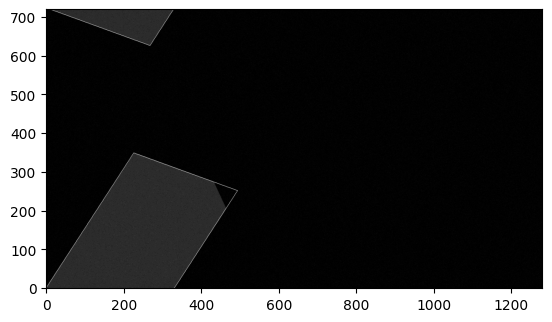

In [63]:
plt.imshow(translate_image , cmap=plt.cm.gray , vmin = 0 , vmax = 255)
plt.gca().invert_yaxis()

In [74]:
# def rotate(input_image , theta):
#     '''
#     used to rotate the paper image with its shorter side parallel to horizontal line
#     '''
#     longer_side_theta = np.deg2rad(np.min(theta))
#     # print(longer_side_theta , np.rad2deg(longer_side_theta))
#     M = np.mat([[np.cos(longer_side_theta) , -np.sin(longer_side_theta)], [np.sin(longer_side_theta) , np.cos(longer_side_theta)]])
#     inv_M = np.linalg.inv(M)
    
#     # image manipulation
#     H , W = input_image.shape
#     new_image = np.zeros((H,W))

#     for i in range(H):
#         for j in range(W):
#             vec = np.array([i,j]).reshape(-1,1)
#             vec_t = inv_M*vec
#             x , y = int(np.round(vec_t[0])) , int(np.round(vec_t[1]))
#             # print(x,y)
#             try:
#                 new_image[i,j] = input_image[x,y]
#             except:
#                 continue

#     return new_image    

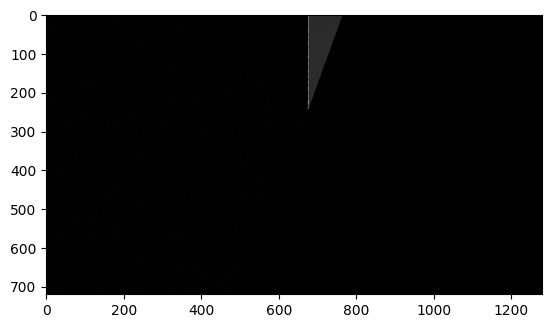

In [75]:
rotated_image = rotate(translate_image , theta)
plt.imshow(rotated_image , cmap=plt.cm.gray)

In [72]:
H , W = rotated_image.shape
back_translate_image = np.zeros((H,W))
for i in range(H):
    for j in range(W):
        back_translate_image[i,j] = rotated_image[i-t_r , j-t_c]

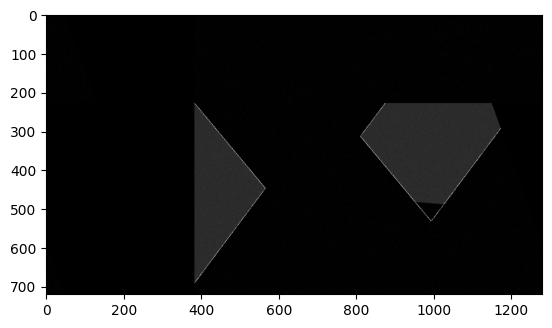

In [73]:
plt.imshow(back_translate_image , cmap=plt.cm.gray)

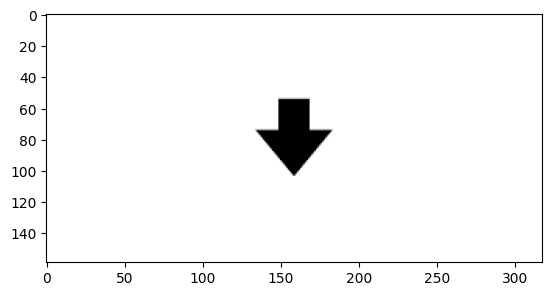

In [35]:
arrow = plt.imread('arrow_test.png')
arrow = np.mean(arrow,axis=2)
plt.imshow(arrow,cmap=plt.cm.gray)
# arrow.shape

In [53]:

# M = np.mat([[1,0],[2,1]])
# inv_M = np.linalg.inv(M)
inv_M = M
inv_M

matrix([[ 0.98480775, -0.17364818],
        [ 0.17364818,  0.98480775]])

In [ ]:
plt.imshow(input_image , cmap=plt.cm.gray)
# plt.gca().invert_yaxis()

In [77]:
angle = np.deg2rad(10)
M = np.mat([[np.cos(angle) , -np.sin(angle)], [np.sin(angle) , np.cos(angle)]])
inv_M = np.linalg.inv(M)

# image manipulation
# input_image = arrow.copy()
H , W = input_image.shape
new_image = input_image.copy()
for i in range(H):
    for j in range(W):
        vec = np.array([i,j]).reshape(-1,1)
        vec_t = inv_M*vec
        x , y = int(np.round(vec_t[0])) , int(np.round(vec_t[1]))
        # print(vec , vec_t)
        try:
            new_image[i,j] = input_image[x,y]
        except:
            continue

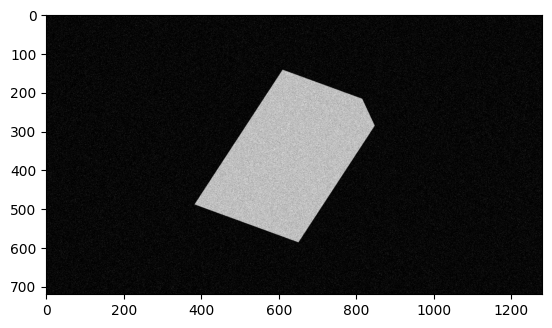

In [81]:
plt.imshow(input_image , cmap=plt.cm.gray)
# plt.gca().invert_yaxis()

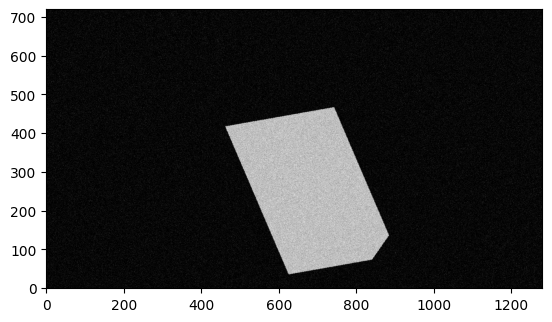

In [80]:
plt.imshow(new_image , cmap=plt.cm.gray)
plt.gca().invert_yaxis()

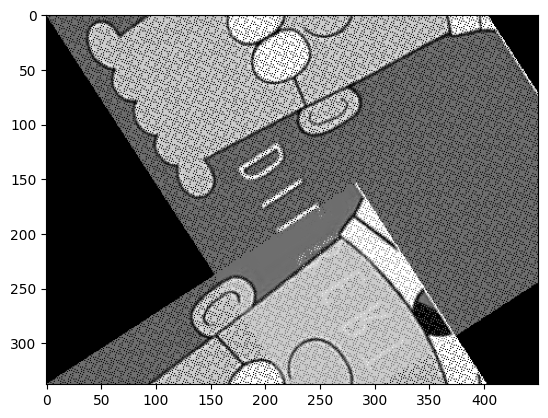

In [33]:
plt.imshow(rotate(dilbert , 33) , cmap=plt.cm.gray)

In [154]:
intersection_grid_X = np.zeros((len(rho) , len(theta)))
intersection_grid_Y = np.zeros((len(rho) , len(theta)))
for i , (rho_i , theta_i) in enumerate(zip(rho , theta)):
    for j , (rho_j , theta_j) in enumerate(zip(rho , theta)):
        intersection_grid_X[i,j] = intersection(rho_i , rho_j , theta_i , theta_j)[0]
        intersection_grid_Y[i,j] = intersection(rho_i , rho_j , theta_i , theta_j)[1]

In [155]:
point_1 = (intersection_grid_X[0,2].astype('int') , intersection_grid_Y[0,2])
point_2 = (intersection_grid_X[0,3] , intersection_grid_Y[0,3])
point_3 = (intersection_grid_X[1,2] , intersection_grid_Y[1,2])
point_4 = (intersection_grid_X[1,3] , intersection_grid_Y[1,3])

In [156]:
point_1

(609.0, 142.0)

In [135]:
rr_1 , cc_1  = line(point_1[0] , point_1[1], point_2[0] , point_2[1])
rr_2 , cc_2  = line(point_1[0] , point_1[1], point_4[0] , point_4[1])
rr_3 , cc_3  = line(point_2[0] , point_2[1], point_3[0] , point_3[1])
rr_4 , cc_4  = line(point_3[0] , point_3[1], point_4[0] , point_4[1])

img = np.zeros((img.shape[0] , img.shape[1]))
img[rr_1 , cc_1] = 255
plt.imshow(img , cmap=plt.cm.gray)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [86]:
# # Line 1
# rr_1 , cc_1 = line(0 , 0 , 100 , 100)
# rr_2 , cc_2 = line(0 , 100 , 100 , 0)

# np.intersect1d(cc_1 , cc_2 , return_indices=True)
# # y_intersects = np.intersect1d(cc_1 , cc_2)

# # np.in

In [87]:
# x = np.array([1, 1, 2, 3, 4])
# y = np.array([2, 1, 4, 6])
# xy, x_ind, y_ind = np.intersect1d(x, y, return_indices=True)
# x_ind, y_ind

In [153]:
def intersection(rho_1 , rho_2 , theta_1 , theta_2):
    '''
    finds intersection point b/w line with params rho and theta
    '''
    if theta_1 != theta_2:
        denom = (np.sin(np.deg2rad(theta_2))*np.cos(np.deg2rad(theta_1)) - np.sin(np.deg2rad(theta_1))*np.cos(np.deg2rad(theta_2)))
        x = (rho_1*np.sin(np.deg2rad(theta_2)) - rho_2*np.sin(np.deg2rad(theta_1)))/denom
        y = (rho_2*np.cos(np.deg2rad(theta_1)) - rho_1*np.cos(np.deg2rad(theta_2)))/denom
        return (np.round(x).astype('int') , np.round(y).astype('int'))
    else:
        return (np.Inf , np.Inf)

In [100]:
intersection(rho[0] , rho[1] , theta[0] , theta[1])

(inf, inf)

In [73]:
intersection(rho[0] , rho[3] , theta[0] , theta[3])

(877.101799525311, 239.42561451284166)

In [93]:
rho , theta

(array([-75, 328, 329, 588, 589, 866, 867], dtype=int64),
 array([110, 110, 110,  33,  33,  33,  33], dtype=int64))

In [70]:
# 2863-2*np.sqrt(720**2+1280**2)
np.sqrt(720**2+1280**2)

1468.6047800548656

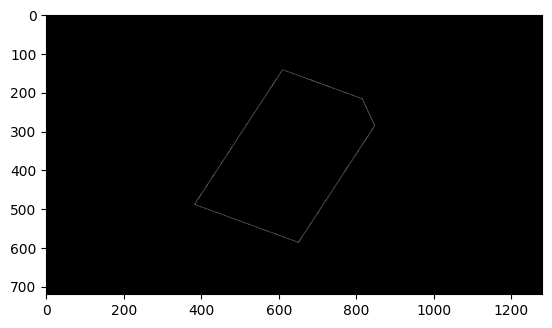

In [49]:
plt.imshow(nms_thresh_image,cmap=plt.cm.gray,vmin=0,vmax=255)

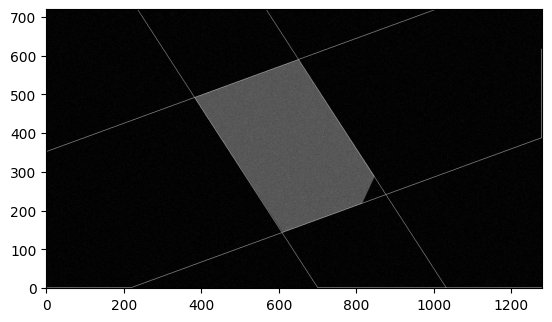

In [50]:
plt.imshow(img,cmap=plt.cm.gray,vmin=0,vmax=255)
plt.gca().invert_yaxis()

In [46]:
list(zip(rho , theta))

[(-75, 110), (329, 110), (588, 33), (866, 33)]

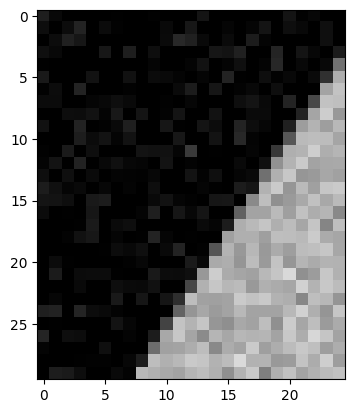

In [46]:
plt.imshow(input_image[270:300,500:525],cmap=plt.cm.gray,vmin=0,vmax=255)

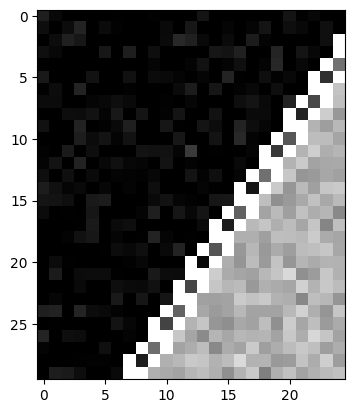

In [30]:
plt.imshow(img[270:300,500:525],cmap=plt.cm.gray,vmin=0,vmax=255)

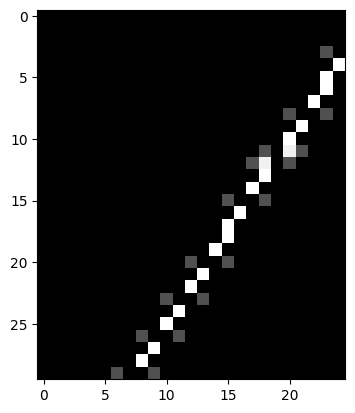

In [31]:
plt.imshow(nms_thresh_image[270:300,500:525],cmap=plt.cm.gray,vmin=0,vmax=255)

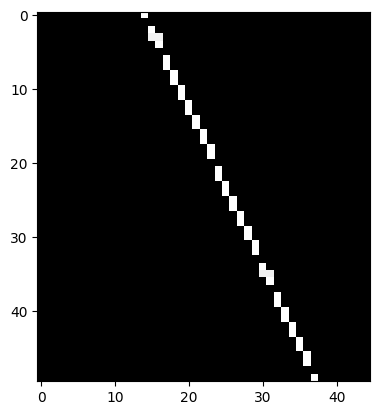

In [96]:
plt.imshow(nms_thresh_image[225:275,805:850],cmap=plt.cm.gray,vmin=0,vmax=255)

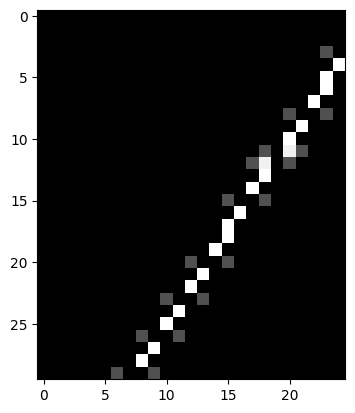

In [93]:
plt.imshow(nms_thresh_image[270:300,500:525],cmap=plt.cm.gray,vmin=0,vmax=255)

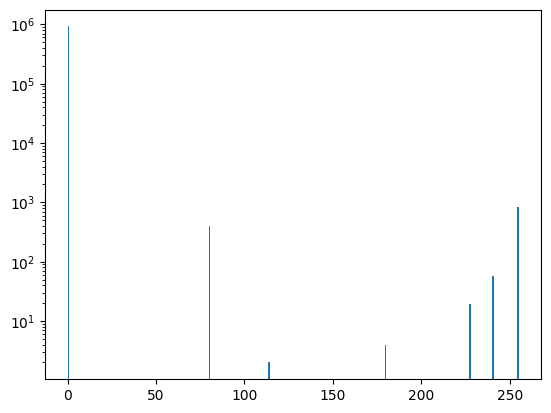

In [78]:
plt.hist(nms_thresh_image.ravel() , bins=256 , log = True);

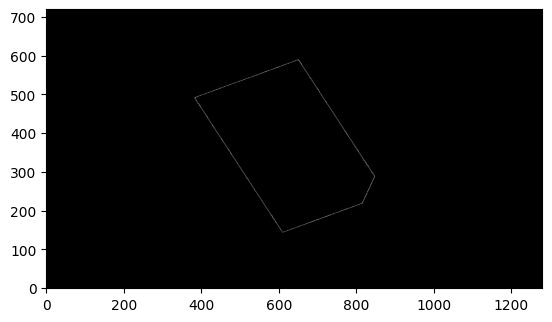

In [120]:
plt.imshow(nms_thresh_image,cmap=plt.cm.gray,vmin=0,vmax=255)
plt.gca().invert_yaxis();

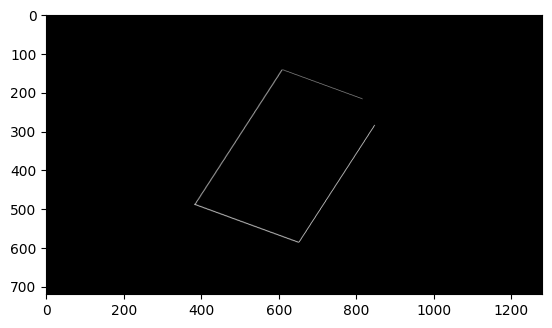

In [112]:
# plt.imshow(img[270:300,500:525],cmap=plt.cm.gray,vmin=0,vmax=255)
plt.imshow(img,cmap=plt.cm.gray,vmin=0,vmax=255)

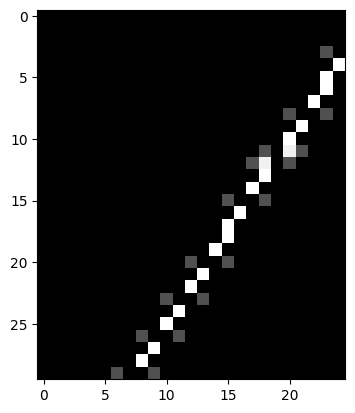

In [113]:
plt.imshow(nms_thresh_image[270:300,500:525],cmap=plt.cm.gray,vmin=0,vmax=255)

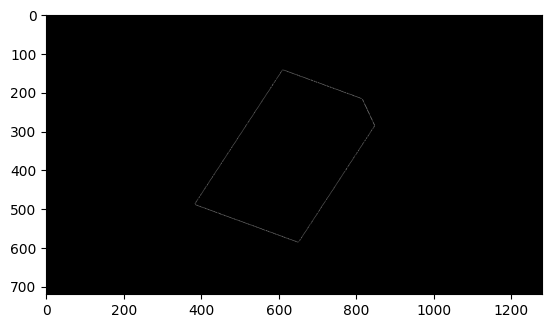

In [124]:
H,W = nms_thresh_image.shape
new_im = np.zeros((H,W))
for i in range(H):
    for j in range(W):
        if nms_thresh_image[i,j] >= 255:
            new_im[i,j] = 255
        else:
            new_im[i,j] = 0

plt.imshow(new_im , cmap=plt.cm.gray,vmin=0,vmax=255)

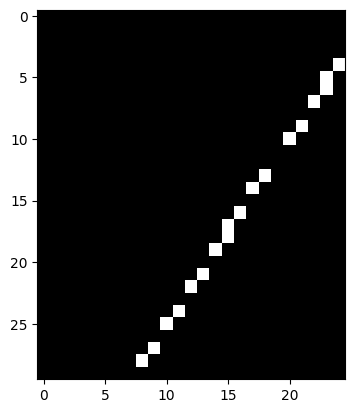

In [125]:
plt.imshow(new_im[270:300,500:525],cmap=plt.cm.gray,vmin=0,vmax=255)

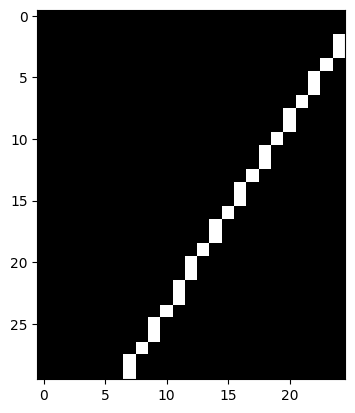

In [118]:
plt.imshow(img[270:300,500:525],cmap=plt.cm.gray,vmin=0,vmax=255)

In [121]:
rho , thetqaa

(array([-75, 329, 588, 866], dtype=int64),
 array([110, 110,  33,  33], dtype=int64))

In [11]:
Z = nms(thresh_image_grad , image_angle)

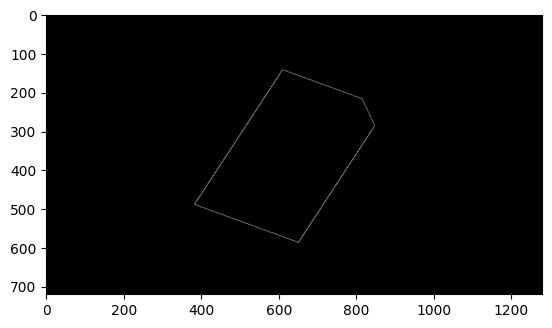

In [12]:
plt.imshow(Z , cmap=plt.cm.gray)

In [45]:
rho , theta = my_hough_transform(Z , threshold = 132)
img = draw_lines(input_image*0.3 , Z , rho , theta , intensity_thresh = 50)

In [46]:
rho , theta

(array([-75, 329, 588, 589, 866, 867], dtype=int64),
 array([110, 110,  33,  33,  33,  33], dtype=int64))

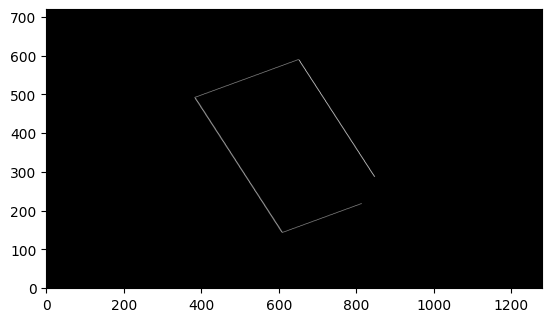

In [47]:
plt.imshow(img , cmap=plt.cm.gray)
plt.gca().invert_yaxis()

In [53]:
np.unique(thresh_image_grad)

array([   0.        ,  360.62445841,  510.        ,  721.24891681,
        806.38080334, 1020.        , 1081.87337522, 1140.39466852])

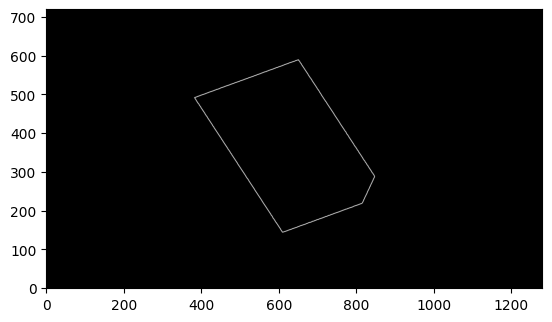

In [51]:
plt.imshow(thresh_image_grad,cmap=plt.cm.gray)
plt.gca().invert_yaxis()

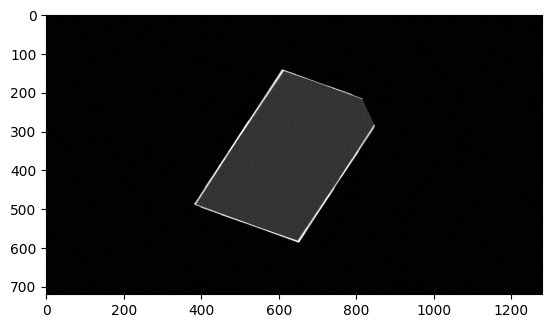

In [49]:
plt.imshow(img,cmap=plt.cm.gray)

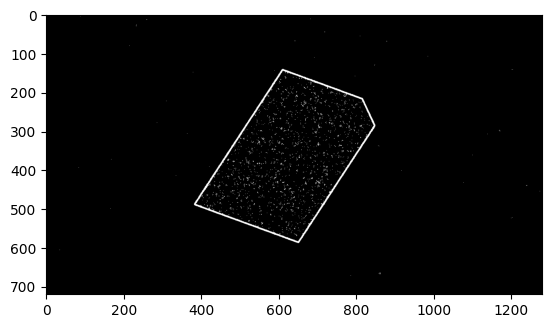

In [51]:
plt.imshow(thresh_image_grad,cmap=plt.cm.gray)

In [ ]:
def my_paper_detection(input_image):
    """Description:
    This function extracts a paper by using the Hough transform method.
    Not all four paper corners are visible in the image, e.g., one may be missing due to paper folding.
    The paper is not in rectangular shape due to viewpoint change.
    It is assumed that the paper has clear boundary.
    The implementation of the Hough transform follows the details given in the Line and Circle Detection lecture notes and tutorial.
    The implementation of the geometric transformations follows the details given in the lecture notes and tutorial.
    Intensity values outside the image region are assumed zero.

    Parameter: input_image = input array representing an image.
    There is only one paper inside the image.
    The paper shape may not be rectangular.
    Some paper corners may be missing.

    Return:
    new_image_line = an original image with four white straight line segments (intensity = 255) outlining the paper boundaries. 
      For each straight line segment, it represents one side of the paper.
    new_image_rotate = the rotated version of new_image_line with the short sides of the paper parallel with a horizontal line.
      The rotation center is the left end of the straight line segment lying on the lower short side. (Bottom left corner.)
      The image sizes of new_image_rotate and new_image_line are the same. Empty space is zero-padded. 
    new_image_shear = the sheared version of the new_image_rotate with the long sides parallel with a vertical line.
      The shear center is the left end of the straight line segment lying on the lower short side. (Bottom left corner.)
      The image sizes of new_image_shear and new_image_rotate are the same. Empty space is zero-padded. 
    new_image_region = a binary, black-and-white image.
        The black region (intensity = 0) corresponds to the image background.
        The white region (intensity = 255) corresponds to the region enclosed by the four straight line segments after rotation and shear.

    Requirements:
    Pre-defined functions for Hough transform cannot be used.
    Pre-defined functions for filtering, convolution, correlation cannot be used, e.g., filter2D.
    Pre-defined functions for rotation, shearing, and geometric transformation cannot be used.
    You must use double for-loop for accessing pixels in the input image.

    Marking criteria:
    The output images will be marked.
    No mark if the operation is not Hough transform and geometric transformation.
    No mark if the implementation does not follow details given the lecture notes and tutorial.
    Mark deduction if image aliasing is observed. 
    Partial marking is possible.
    """

    # create a new image which is identical to input image
    H, W = input_image.shape
    new_image_line = np.zeros((H, W))
    new_image_rotate = np.zeros((H, W))
    new_image_shear = np.zeros((H, W))
    new_image_region = np.zeros((H, W))

    ############################
    # [Your code goes here]
    ############################

    # This dummy code block can be removed after entering your code
    new_image_line = input_image.copy()
    rr, cc, val = line_aa(300, 300, 500, 500)
    new_image_line[rr, cc] = 255.0
    new_image_rotate = new_image_line.copy()
    new_image_shear = new_image_rotate.copy()
    new_image_region = new_image_shear.copy()

    ############################
    # [Your code ends here]
    ############################

    return new_image_line, new_image_rotate, new_image_shear, new_image_region